In [29]:
import featureDetection as fdet
import cv2
import numpy as np

In [30]:
import os
import matplotlib.pyplot as plt
# os.chdir('./code')
# img_path = './test/pattern.jpg'
# img_path = '../../data/230411/3_wrapped.png'
img_path = '../../data/din/9_wrapped.png'
img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
img1 = cv2.resize(img1, (int(img1.shape[1]/2), int(img1.shape[0]/2)))
# argmax, anms
# rsp, ftx, fty = HarrisCorner(img, nm='anms', n=100)
# rsp1, ftx1, fty1 = fdet.multiscaleHarris(img1, n=n, nm='argmax')

In [31]:
n=2000
nm='argmax'
imgs, scaleMap, ftx, fty = fdet.multiscaleHarris(img1, n=n, des=True, nm=nm)

In [32]:
def patch2Haar(patch):
    h8 = haarMatrix(8)
    return np.matmul(h8.T, np.matmul(patch, h8))


def haarMatrix(n, normalized=False):
    # reference from wiki
    n = 2**np.ceil(np.log2(n))
    if n > 2:
        h = haarMatrix(n / 2)
    else:
        return np.array([[1, 1], [1, -1]])
    h_n = np.kron(h, [1, 1])
    if normalized:
        h_i = np.sqrt(n/2)*np.kron(np.eye(len(h)), [1, -1])
    else:
        h_i = np.kron(np.eye(len(h)), [1, -1])
    h = np.vstack((h_n, h_i))
    return h


def findPatch(img, fx, fy, angle):
    p_size = 40
    patch = np.zeros((p_size, p_size))
    for i in range(p_size):
        for j in range(p_size):
            x0 = i - p_size/2
            y0 = j - p_size/2
            angle0 = np.arctan(y0/(x0+1e-8))
            angle0 += np.pi if x0 < 0 else 0
            r = np.sqrt(x0*x0+y0*y0)
            x1 = round(r*np.cos(angle0+angle) + fx)
            y1 = round(r*np.sin(angle0+angle) + fy)
            if 0 <= x1 < img.shape[0] and 0 <= y1 < img.shape[1]:
                patch[i, j] = img[x1, y1]
#     patch = patch[::5, ::5]
    patch = cv2.resize(patch, (8, 8))
    patch = (patch-np.mean(patch))/np.std(patch)
    return patch

In [33]:
# import featureDescriptor as fdes
def descriptor(imgs, scaleMap, ftx, fty):
    # imgs is a image set contain images of different scales.
    blurs = [fdet.gaussian_filter(img, kernel_size=3, sigma=4.5) for img in imgs]
    oriMaps = []
    for img in blurs:
        ix, iy = fdet.sobel_filter(img)
        # using image corrdinate system. x-down, y-right. oriMap in radian.
        oriMaps.append(np.arctan(ix/(iy+1e-8)))
    
    featureVectors = []
    for i in range(len(ftx)):
        l = scaleMap[ftx[i], fty[i]].astype(int)
        fx = ftx[i]/np.power(2, l)
        fy = fty[i]/np.power(2, l)
        angle = oriMaps[l][int(fx), int(fy)]
        patch = findPatch(blurs[l], fx, fy, angle)
        featureVectors.append(patch2Haar(patch).ravel())
    return np.array(featureVectors)
featureVectors = descriptor(imgs, scaleMap, ftx, fty)

In [34]:
# img_path = '../../data/230411/4_wrapped.png'
img_path = '../../data/din/0_wrapped.png'
img2 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img2, (int(img2.shape[1]/2), int(img2.shape[0]/2)))

imgs2, scaleMap2, ftx2, fty2 = fdet.multiscaleHarris(img2, n=n, des=True, nm=nm)
featureVectors2 = descriptor(imgs2, scaleMap2, ftx2, fty2)

In [35]:
import math
dmin = math.dist(featureVectors[0], featureVectors2[0])
match_point = np.array([[0, 0, dmin]])
# print(match_point)
for i in range(len(featureVectors)):
    dmin = math.dist(featureVectors[i], featureVectors2[0])
    matchpt = [i, 0, dmin]
    for j in range(len(featureVectors2)-1):
        e1 = math.dist(featureVectors[i], featureVectors2[j])
        if e1 < dmin:
            dmin = e1
            matchpt = [i, j, dmin]
    if matchpt[1] in match_point[:, 1]:
        for pt in np.argwhere(match_point[:, 1]==matchpt[1]):
#             print(pt)
            if matchpt[2] < match_point[pt[0], 2]:
                match_point[pt[0]] = matchpt
    else:
        match_point = np.append(match_point, [matchpt], axis=0)
print(match_point.shape)
# print(match_point)

(801, 3)


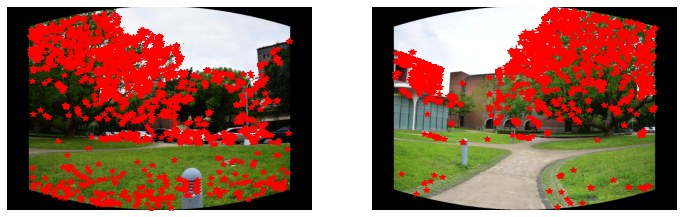

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img1)
for pt in zip(ftx, fty):
    plt.plot(pt[1], pt[0], 'r*')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(img2)
for pt in zip(ftx2, fty2):
    plt.plot(pt[1], pt[0], 'r*')
# plt.savefig('Harris_anms.png')

plt.savefig('imgs_feature.png')
plt.show()

305


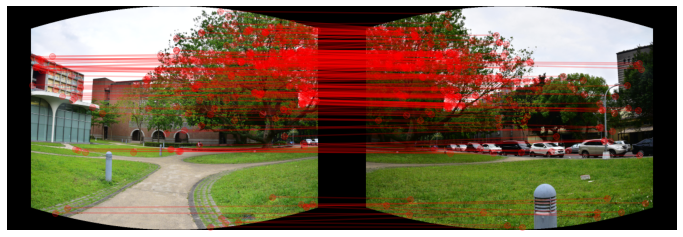

In [40]:
img_12 = cv2.hconcat([img2, img1])
a=0
plt.figure(figsize=(12, 6))
plt.axis('off')
plt.imshow(img_12)
for mp in match_point:
#     x1 = fty[int(mp[0])]
#     x2 = fty2[int(mp[1])]+img1.shape[1]
#     y1 = ftx[int(mp[0])]
#     y2 = ftx2[int(mp[1])]
    x2 = fty[int(mp[0])]+img1.shape[1]
    x1 = fty2[int(mp[1])]
    y2 = ftx[int(mp[0])]
    y1 = ftx2[int(mp[1])]
#     plt.plot([x1, x2], [y1, y2], 'bo-', alpha=0.8)
    if abs(y2-y1) < img1.shape[0]/16:
        plt.plot([x1, x2], [y1, y2], 'ro-', alpha=0.2)
        a+=1

#     plt.plot([x1, x2], [y1, y2], 'ro-')
#     if abs(y2-y1) < 32:
#         plt.plot([x1, x2], [y1, y2], 'wo-', alpha=0.5)
#         a+=1
#     if mp[2]<10:
    
print(a)
# plt.savefig('Harris_anms.png')
plt.savefig('feature_matching.png')
plt.show()

In [38]:
# dstPoints,srcPoints,imgLeft,imgRight = yun_S_part(imgLeft, imgRight)          
## dstPoints: left img的feature points  
## srcPoints: right img的feature points
print('len(match_point): ', len(match_point))
def ransac(ftx1, fty1, ftx2, fty2, matchpoint):
#     pt1 = []
    import random
    hmp = []
    for mp in matchpoint:
        x1 = fty1[int(mp[0])]
        x2 = fty2[int(mp[1])]+fty2.max()
        y1 = ftx1[int(mp[0])]
        y2 = ftx2[int(mp[1])]
        if abs(y2-y1) < 32 and abs(x2-x1) < fty2.max()*3/5:
            hmp.append([mp[0], mp[1]])
    hmp = np.array(hmp).astype(int)
    print('hmp:', hmp.shape)
    p = 0.99
    k = 100000
    print('k: ', k)
    sigma = ftx1.max()/8
#     best_a = 0
#     best_b = 0
    pretotal = 0
    best_ptin = []
#     n=100
#     while len(best_ptin)<n:
    for i in range(k):
        sample_index = random.sample(range(len(hmp)), 2)
        x1 = fty1[hmp[sample_index[0], 0]]
        x2 = fty1[hmp[sample_index[1], 0]]
        y1 = ftx1[hmp[sample_index[0], 0]]
        y2 = ftx1[hmp[sample_index[1], 0]]
        a = (y2 - y1) / (x2 - x1 + 1e-8)
        b = y1 - a * x1

        total_inlier = 0
        ptin = []
        for j, pt1 in enumerate(hmp):
            xj = fty1[pt1[0]]
            yj = ftx1[pt1[0]]
            y_estimate = a * xj + b
            if abs(y_estimate - yj) < sigma:
                ptin.append(pt1)
                total_inlier += 1

        if total_inlier > pretotal:
#             print(ptin)
            pretotal = total_inlier
            best_ptin = np.array(ptin)
#             best_a = a
#             best_b = b
    print(len(best_ptin))
    return best_ptin.astype(int)
    
ptin = ransac(ftx, fty, ftx2, fty2, match_point)
print(ptin.shape)

len(match_point):  801
hmp: (20, 2)
k:  100000
15
(15, 2)


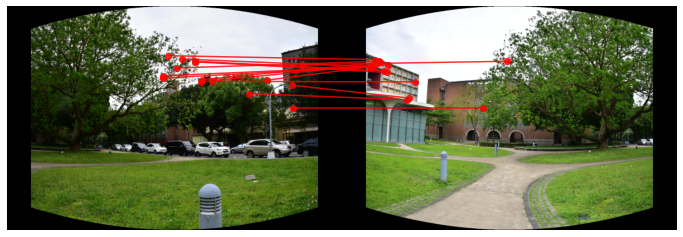

In [39]:
img_12 = cv2.hconcat([img1, img2])
a=0
plt.figure(figsize=(12, 6))
plt.axis('off')
plt.imshow(img_12)
for mp in ptin:
#     print(mp)
    x1 = fty[int(mp[0])]
    x2 = fty2[int(mp[1])]+img1.shape[1]
    y1 = ftx[int(mp[0])]
    y2 = ftx2[int(mp[1])]
    plt.plot([x1, x2], [y1, y2], 'ro-', alpha=0.8)
plt.savefig('feature_matching_ransac.png')
plt.show()